## Gender in a million headlines

**What can headlines from the Australian national broadcaster (the ABC) tell us 
about the concerns of the Australian public over time, where those concerns 
relate to male and/or female persons?**

In [1]:
import osOps  # see github.com/romstroller/FileTools

from collections import Counter
import pandas as pd
import nltk
import os

import matplotlib.pyplot as plt

### Data acquisition, cleaning and feature engineering

In [2]:
dfOrig = osOps.OsKit().getKaggleSet( 'therohk', 'million-headlines' )

- [221005_231412507866] Waiting for API request
- [221005_231413517425] Got million-headlines.zip
- [221005_231413765618] Read DF from extracted set


The most flexible / granular set of data would be a list comprised of all the 
words in all headlines, each paired to the date of the headline in which they 
featured.

In [3]:
# split headlines into word-by-date
df = pd.DataFrame( dfOrig.headline_text.str.split( ' ' ).tolist(),
    index=dfOrig.publish_date ).stack().reset_index( inplace=False )
df.rename( columns={ 0: 'word', 'publish_date': 'date' }, inplace=True )
del df[ 'level_1' ]
df

,date,word
0,20030219,aba
1,20030219,decides
2,20030219,against
3,20030219,community
4,20030219,broadcasting
...,...,...
8158762,20211231,here
8158763,20211231,are
8158764,20211231,the
8158765,20211231,new


#### Assumptions and definitions

It is important to point out that there is no guaranteed metric available
for the "concerns" of an audience, unless a profoundly narrowed definition
for concern is approximated using, for example, a set of behavioural indicators.

In the limitations of this dataset, we will need to equate "concern" with the
prominence of particular patterns of reference. This speaks more directly to the 
"concern" of ABC-published journalism. 

To conduct the project, we make the assumption that public concern may be 
estimated by the frequency of words in a headline ("headwords") that appear 
together in a manner indicating uniform objects of communication. 

*Concern* is thus "headword frequency", or headword-count-at-date.

#### Gender keywords

More specifically, gendered individuals as objects of communication will (in a 
set where non-gendered stopwords are omitted) be estimated to occur:

- Variant one (drafted): for males, equally with "man" and "men", and for females, likewise with "woman" 
and "women".
- Variant two (extend):
 - Include "male", "males", "man", "men, "female", "females", "woman", "women"
 - "for males, equally for occurances of "he", "him", "his", "himself" ( and 
common syntactical variations like "he's" and "he'd" ) and equivalently for 
females with "she", "her", "hers", "herself"."
 - "boys", "boy", "girl", "girls"

#### Get count

In [4]:
# testing counter
wordcount = Counter( df[ 'word' ].tolist() )
wordcount.most_common()[ :25 ]

[('to', 238375),
 ('in', 156175),
 ('for', 143272),
 ('of', 95940),
 ('on', 82014),
 ('the', 65048),
 ('over', 54527),
 ('police', 39813),
 ('at', 36887),
 ('with', 36331),
 ('after', 34641),
 ('new', 33729),
 ('a', 31148),
 ('man', 30627),
 ('and', 30069),
 ('as', 24333),
 ('says', 23731),
 ('from', 23440),
 ('up', 22872),
 ('by', 21375),
 ('us', 20370),
 ('out', 19117),
 ('be', 18199),
 ('court', 18180),
 ('govt', 17091)]

#### Get count omitting stopwords

In [5]:
nltk.download( 'stopwords', download_dir=os.getcwd() )

with open( "corpora\stopwords\english", 'r' ) as f:
    stopwords = [ line.strip() for line in f ]

# stopwords includes:
#      'he',
#      'him',
#      'his',
#      'himself',
#      'she',
#      "she's",
#      'her',
#      'hers',
#      'herself',

stopwordsV1 = [ w for w in stopwords if w not in [
    "man", "men", "woman", "women" ] ]

dfNonStopV1 = df[ ~df[ 'word' ].isin( stopwordsV1 ) ]

# re-testing counter
wordcount = Counter( dfNonStopV1[ 'word' ].tolist() )
wdCountSt = wordcount.most_common()
wdCountSt[ :25 ]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romstroller\PYC\millionHeadlines...
[nltk_data]   Package stopwords is already up-to-date!


[('police', 39813),
 ('new', 33729),
 ('man', 30627),
 ('says', 23731),
 ('us', 20370),
 ('court', 18180),
 ('govt', 17091),
 ('australia', 17071),
 ('council', 16955),
 ('nsw', 16516),
 ('fire', 15512),
 ('interview', 15426),
 ('australian', 13632),
 ('wa', 13464),
 ('sydney', 13065),
 ('plan', 12993),
 ('water', 12850),
 ('death', 12749),
 ('qld', 12590),
 ('crash', 12356),
 ('health', 11967),
 ('back', 11221),
 ('charged', 11193),
 ('murder', 10529),
 ('report', 10413)]

## Analysis, Interpretation, Visualisation

#### Initial observations

A glaring insight for our objective is already available at this point:
*man* is the third-most common word altogether, gendered or otherwise, in 
this cleaned dataset, while none of our female headwords are even in the 
top 25. How are the female headwords ranked?

In [6]:
print( [ f"pos {i}: {x[ 0 ]} (cnt {x[ 1 ]})" for i, x in enumerate( wdCountSt )
    if x[ 0 ] in [ "man", "men", "woman", "women" ] ] )

['pos 2: man (cnt 30627)', 'pos 36: woman (cnt 9463)', 'pos 245: women (cnt 3867)', 'pos 320: men (cnt 3160)']


"Woman" doesn't get in the ranking until 37th, and over three times 
less-frequently than "man". Somewhat interestingly, "women" then appears at 
246th, some ways above "men" at 321th. In the simplistic limitations of our 
analysis, if a group of gendered people is of concern, it is more likely to be 
of women, while if a gendered individual is of concern, it is more likely to be 
a man. 

In [7]:
# produce dfs grouping monthly counts for each gender headword set 
genDfs = [ ]
for ttl, gdr in { 'men': [ "man", "men" ], 'wom': [ "woman", "women" ] }.items():
    gDf = pd.concat( [
        dfNonStopV1[ dfNonStopV1.word == gdr[ 0 ] ],
        dfNonStopV1[ dfNonStopV1.word == gdr[ 1 ] ]
        ], axis=0 ).sort_values( by=[ 'date' ], ascending=True )
    gDf[ 'date' ] = gDf[ 'date' ].astype( str ).str[ :6 ]  # by month; disab for linegr?
    gDf = gDf.groupby( 'date' ).size().reset_index( name=f'{ttl}Count' )
    genDfs.append( gDf )

# menDf, femDf = genDfs
merged = pd.merge( genDfs[ 0 ], genDfs[ 1 ], on='date' ).set_index( 'date' )
newcols = [ ''.join( col ).strip() for col in merged.columns.values ]
merged.reset_index( inplace=True )
df = merged.sort_values( by='date', ascending=True ).astype( int )

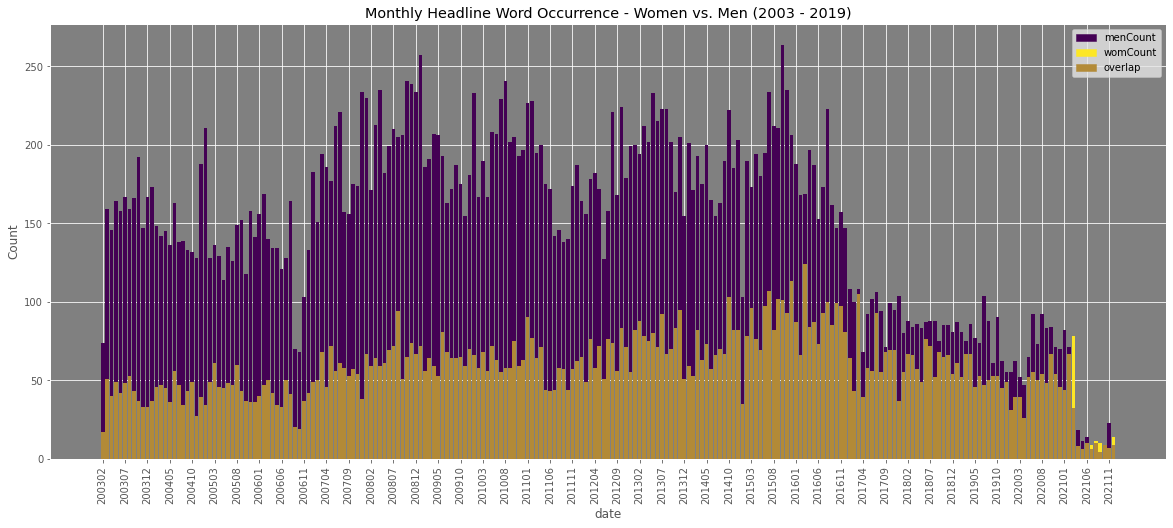

In [16]:
# make as def (df, figsize; test as line plot)

def plotOverlapping( _df, _xFt, _frontYft, _rearYft, yLab, figsiz, title = "", ):
    plt.style.use( 'ggplot' )
    plt.figure( figsize=figsiz, facecolor="white", )
    
    x = _df[ _xFt ]
    xpos = [ i for i, _ in enumerate( x ) ]
    
    cols = { _frontYft: '#440154', _rearYft: '#fde725', 'overlap': "#b38b38" }
    
    plt.bar( xpos, _df[ _rearYft ], color=cols[ _rearYft ] )
    plt.bar( xpos, _df[ _frontYft ], color=cols[ _frontYft ] )
    plt.bar( xpos, _df[ _rearYft ], color=cols[ _rearYft ], alpha=0.6 )
    ax1 = plt.gca()
    ax1.set_facecolor( '#808080' )
    
    plt.xlabel( _xFt )
    plt.ylabel( yLab )
    plt.title( title )
    plt.xticks( xpos, x )
    plt.xticks( rotation=90 )
    ax1.locator_params( nbins=50, axis='x' )
    
    labs = list( cols.keys() )
    plt.legend( [ plt.Rectangle( (0, 0), 1, 1, color=cols[ lb ] )
        for lb in labs ], labs )
    
    plt.savefig( f'ghp_full{osOps.OsKit().dtStamp()}.png', bbox_inches='tight' )
    plt.show()


plotOverlapping( df, 'date', 'menCount', 'womCount', "Count", (20, 8),
    title="Monthly Headline Word Occurrence - Women vs. Men (2003 - 2019)" )

In [9]:
# First date where womCount equals or exceeds menCount
firstParity = df.loc[ df[ 'womCount' ] >= df[ 'menCount' ], 'date' ].iloc[ 0 ]
df_202101 = df[ df[ 'date' ] > firstParity - 3 ]


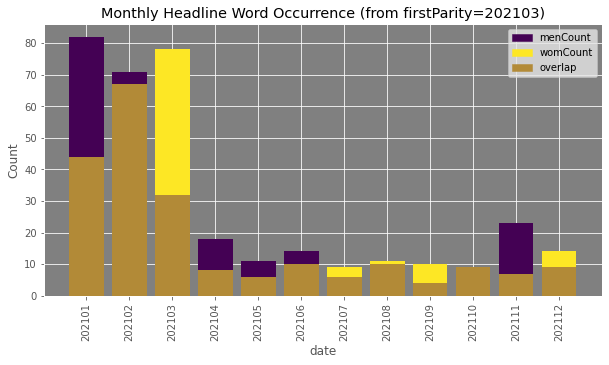

In [17]:
plotOverlapping( df_202101, 'date', 'menCount', 'womCount', "Count", (10, 5),
    title=f"Monthly Headline Word Occurrence (from {firstParity=})" )

In [11]:
# breakdown parity-focus segment into daily
# show percentages along with summaries,
#   + sep viz for percentage of total

#### Summary observations

- Men are consistently mentioned more often than women until {}
- For the most part, women are mentioned {} as often as men
- {Around the beginning of 2013}, women rise to around half men-mentions 
- From the beginning of 2017, women begin to draw close to parity with men, 
ending at around {4/5} the mention rate of men.
- That this convergence is the result of the words "men" and "man" being 
used less, rather than "woman" and "women" being used more
- Before parity is finally reached, the closest month to parity (March 2017) 
includes International Women's Day on the 8th.
- parity is reached and exceeded 202103 and then several times shortly after (?)

**Key interpretation: the public concern for stories dominated by either gender 
in particular as drawn significantly close to parity in recent years, while 
women remain consistently less in-focus than men.**